### Pairwise Euclidean Distance Boxplots

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter

from sklearn.model_selection import train_test_split

import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models import resnet
from tqdm import tqdm 
import torchvision
import torchvision.transforms as T

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import PIL
import copy

import catalyst.dl as dl
from catalyst.contrib.nn import (
    ArcFace,
    CosFace,
    AdaCos,
    SubCenterArcFace,
    CurricularFace,
    ArcMarginProduct,
)

/users/PAS2136/ramirez528/.conda/envs/classification_exp_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# gradcam: https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Device: ",device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Device:  cpu


## Select Acuity and Model

In [67]:
## ----- uncomment the name of the dataset you want to work with ------
# acuity = 'no_acuity_white_background'
acuity = 'no_acuity'
# acuity = 'heliconius_male_behavioral_acuity'
# acuity = 'heliconius_female_behavioral_acuity'
# acuity = 'heliconius_male_morphological_acuity'
# acuity = 'heliconius_female_morphological_acuity'
# acuity = 'kingfisher_acuity'

## ----- uncomment model name ------
# model_name = 'RegularSpeciesClassification'
# model_name = 'EratoNet' #Done
model_name = 'MelpomeneNet' #method works, Done

print('Acuity: ', acuity)
print('Model: ', model_name)

Acuity:  no_acuity
Model:  MelpomeneNet


In [68]:
print(model_name)
if model_name == 'EratoNet':
    erato_net = True
    melpomene_net = False
    mimic_net = False
    n_classes = 10

elif model_name == 'MelpomeneNet':
    erato_net = False
    melpomene_net = True
    mimic_net = False
    n_classes = 10
    
elif model_name == 'MimicsNet':
    erato_net = False
    melpomene_net = False
    mimic_net = True
    n_classes = 10
    
elif model_name == 'RegularSpeciesClassification':
    erato_net = False
    melpomene_net = False
    mimic_net = False
    n_classes = 20

num_classes = n_classes
num_classes

MelpomeneNet


10

## Data

Get the path to the dataset containing the images we want to work with

In [69]:
from src.dir_paths.dataset_paths import get_image_dataset_path
from src.dir_paths.train_val_test_paths import get_split_csvs

#path to images with the applied selected acuity
dataset_path = get_image_dataset_path(acuity)

#path to train/val/test split csvs 
main = get_split_csvs(acuity, model_name)

print('Image Dataset:', dataset_path)
print('Data Split: ', main)

Image Dataset: /fs/ess/PAS2136/Butterfly/Model_Mimic/model_mimic_images_256_256_removed_background_dorsal/
Data Split:  /fs/ess/PAS2136/Butterfly/Model_Mimic/Data_Splits/MelpomeneNet/model_mimic_images_256_256_removed_background_dorsal/


## Map species string labels to categorical numerical labels

In [70]:
#using the structure of subspecies folders, assign a numerical categorical id to each subspecies
# species_list = os.listdir(dataset_path)
# species2index = {species:i for i, species in enumerate(species_list)}
# index2species = {i:species for i, species in enumerate(species_list)}
# display(index2species)

index2species = {0: 'Heliconius melpomene ssp. ecuadorensis',
 1: 'Heliconius melpomene ssp. nanna',
 2: 'Heliconius melpomene ssp. rosina',
 3: 'Heliconius erato ssp. phyllis',
 4: 'Heliconius erato ssp. dignus',
 5: 'Heliconius melpomene ssp. bellula',
 6: 'Heliconius erato ssp. lativitta',
 7: 'Heliconius melpomene ssp. vulcanus',
 8: 'Heliconius erato ssp. etylus',
 9: 'Heliconius melpomene ssp. plesseni',
 10: 'Heliconius melpomene ssp. malleti',
 11: 'Heliconius erato ssp. cyrbia',
 12: 'Heliconius erato ssp. amalfreda',
 13: 'Heliconius erato ssp. venus',
 14: 'Heliconius erato ssp. hydara',
 15: 'Heliconius melpomene ssp. meriana', 
 16: 'Heliconius erato ssp. petiverana',
 17: 'Heliconius melpomene ssp. cythera',
 18: 'Heliconius erato ssp. notabilis',
 19: 'Heliconius melpomene ssp. melpomene'}

species2index = {v:k for k,v in index2species.items()}

comimic_dict = {"Heliconius melpomene ssp. malleti": "Heliconius erato ssp. lativitta",
                "Heliconius melpomene ssp. melpomene": "Heliconius erato ssp. hydara", 
                "Heliconius melpomene ssp. plesseni": "Heliconius erato ssp. notabilis",
                "Heliconius melpomene ssp. vulcanus": "Heliconius erato ssp. venus",
                "Heliconius melpomene ssp. rosina": "Heliconius erato ssp. petiverana",
                "Heliconius melpomene ssp. cythera": "Heliconius erato ssp. cyrbia", 
                "Heliconius melpomene ssp. nanna": "Heliconius erato ssp. phyllis",
                "Heliconius melpomene ssp. bellula": "Heliconius erato ssp. dignus",
                "Heliconius melpomene ssp. ecuadorensis": "Heliconius erato ssp. etylus", 
                "Heliconius melpomene ssp. meriana": "Heliconius erato ssp. amalfreda"}

index2species_erato = {
0: 'Heliconius erato ssp. phyllis',
1: 'Heliconius erato ssp. dignus',
2: 'Heliconius erato ssp. lativitta',
3: 'Heliconius erato ssp. etylus',
4: 'Heliconius erato ssp. cyrbia',
5: 'Heliconius erato ssp. amalfreda', #meriana is the melpomene mimic
6: 'Heliconius erato ssp. venus',
7: 'Heliconius erato ssp. hydara',
8: 'Heliconius erato ssp. petiverana',
9: 'Heliconius erato ssp. notabilis'}

index2species_melpomene = {
0: 'Heliconius melpomene ssp. nanna',
1: 'Heliconius melpomene ssp. bellula',
2: 'Heliconius melpomene ssp. malleti',
3: 'Heliconius melpomene ssp. ecuadorensis',
4: 'Heliconius melpomene ssp. cythera',
5: 'Heliconius melpomene ssp. meriana', #Missing from index2species in dorsal images
6: 'Heliconius melpomene ssp. vulcanus',
7: 'Heliconius melpomene ssp. melpomene',
8: 'Heliconius melpomene ssp. rosina',
9: 'Heliconius melpomene ssp. plesseni',
}

index2species_mimics = {
     0:'mimic_0',
     1:'mimic_1',
     2:'mimic_2',
     3:'mimic_3',
     4:'mimic_4',
     5:'mimic_5',
     6:'mimic_6',
     7:'mimic_7',
     8:'mimic_8',
     9:'mimic_9'

}

#indices in the dictionaries above are assigned such that the mimic pair will share the same numerical label

species2index_erato = {v:k for k,v in index2species_erato.items()}
species2index_melpomene = {v:k for k,v in index2species_melpomene.items()}

species2index_mimics = copy.deepcopy(species2index_erato)
species2index_mimics.update(species2index_melpomene)

## Read Train/Val/Test Splits

In [71]:
if mimic_net or model_name == 'RegularSpeciesClassification':
    train_df = pd.read_csv(main + 'train.csv')
    val_df = pd.read_csv(main + 'val.csv')
    test_df = pd.read_csv(main + 'test.csv')

    print(train_df.shape) ##2751, 2
    print(val_df.shape) #306, 2
    print(test_df.shape) #765, 2

elif erato_net or melpomene_net:
    train_df = pd.read_csv(main + 'train.csv')
    val_df = pd.read_csv(main + 'val.csv')
    test_df_erato = pd.read_csv(main + 'test_erato.csv')
    test_df_melpomene = pd.read_csv(main + 'test_melpomene.csv')

    print(train_df.shape)
    print(val_df.shape) 
    print(test_df_erato.shape)
    print(test_df_melpomene.shape) 

#Regular and mimics
# (2751, 2)
# (306, 2)
# (765, 2)

#EratoNet (no acuity)
# (1728, 2)
# (241, 2)
# (433, 2)
# (1420, 2)

#MelpomeneNet (no acuity)
# (1022, 2)
# (142, 2)
# (2402, 2)
# (256, 2)

#2402 total erato vs 1420 total melpomene

(1022, 2)
(142, 2)
(2402, 2)
(256, 2)


In [72]:
#making sure data splits for kingfisher add up to 3814 instead of 3822 due to errors with AcuityView processing
1724 + 239 + 433 + 1418 #3814 (8 missing from full 3822 images)
2747 + 305 + 762 #3814
1020 + 142 + 2396 + 256 #3814
2751 + 306 + 765

3822

## Encode Labels for Model

In [73]:
from src.dataloader import read_image, read_sized_image, get_transforms, get_loader

if main.split('/')[7] == "MimicsNet":
    #create lists of image filepaths and their labels for each split
    train_images = list(train_df['path'])
    valid_images = list(val_df['path'])
    test_images = list(test_df['path'])

    #keep a list of the original string labels
    print('Using MimicsNet Labels')
    train_targets_ss = list(train_df['label'])
    valid_targets_ss = list(val_df['label'])
    test_targets_ss = list(test_df['label'])
    
    #encode string subspecies labels --> numbers in a way that mimics share the same label
    train_targets = [species2index_mimics[str(elem).split("/")[7]] for elem in train_images]
    valid_targets = [species2index_mimics[str(elem).split("/")[7]] for elem in valid_images]
    test_targets = [species2index_mimics[str(elem).split("/")[7]] for elem in test_images]
    
elif main.split('/')[7] == "EratoNet":
    print('EratoNet')
    train_images = list(train_df['path'])
    valid_images = list(val_df['path'])
    test_images_erato = list(test_df_erato['path'])
    test_images_melpomene = list(test_df_melpomene['path'])

    train_targets = [species2index_erato[str(elem).split("/")[7]] for elem in train_images]
    valid_targets = [species2index_erato[str(elem).split("/")[7]] for elem in valid_images]
    test_targets_erato = [species2index_erato[str(elem).split("/")[7]] for elem in test_images_erato]
    test_targets_melpomene = [species2index_melpomene[str(elem).split("/")[7]] for elem in test_images_melpomene]
    test_targets_melpomene_actual = [str(elem).split("/")[7] for elem in test_images_melpomene] #so that we have the true melpomene label encodings for each image

    print("Number of train samples -", len(train_images))
    print("Number of valid samples -", len(valid_images))
    print("Number of test erato samples - ",len(test_images_erato))
    print("Number of test melpomene samples - ",len(test_images_melpomene))

elif main.split('/')[7] == "MelpomeneNet":
    print('MelpomeneNet')
    train_images = list(train_df['path'])
    valid_images = list(val_df['path'])
    test_images_erato = list(test_df_erato['path'])
    test_images_melpomene = list(test_df_melpomene['path'])

    train_targets = [species2index_melpomene[str(elem).split("/")[7]] for elem in train_images]
    valid_targets = [species2index_melpomene[str(elem).split("/")[7]] for elem in valid_images]
    test_targets_melpomene = [species2index_melpomene[str(elem).split("/")[7]] for elem in test_images_melpomene]
    test_targets_erato = [species2index_erato[str(elem).split("/")[7]] for elem in test_images_erato]
    test_targets_erato_actual = [str(elem).split("/")[7] for elem in test_images_erato] #so that we have the true erato label encodings for each image

    print("Number of train samples -", len(train_images))
    print("Number of valid samples -", len(valid_images))
    print("Number of test melpomene samples - ",len(test_images_melpomene))
    print("Number of test erato samples - ",len(test_images_erato))

else:
    #regular species classification
    train_images = list(train_df['path'])
    valid_images = list(val_df['path'])
    test_images = list(test_df['path'])

    train_targets = [species2index[str(elem).split("/")[7]] for elem in train_images]
    valid_targets = [species2index[str(elem).split("/")[7]] for elem in valid_images]
    test_targets = [species2index[str(elem).split("/")[7]] for elem in test_images]

    print("Number of train samples -", len(train_images))
    print("Number of valid samples -", len(valid_images))
    print("Number of test samples - ",len(test_images))

#create dataloaders for each split of data
batch = 32
train_dataset, train_loader = get_loader("train", train_images, train_targets, batch_size=batch, num_workers=1)
valid_dataset, valid_loader = get_loader("valid", valid_images, valid_targets, batch_size=batch, num_workers=1)

if erato_net or melpomene_net:
    test_dataset_erato, test_loader_erato, = get_loader("test", test_images_erato, test_targets_erato, batch_size=batch, num_workers=1)
    test_dataset_melpomene, test_loader_melpomene, = get_loader("test", test_images_melpomene, test_targets_melpomene, batch_size=batch, num_workers=1)
    
    #create dictionary with each of our dataloaders
    #only include the ID loader --> leave out the mimic loader for now. We'll work with that one independently
    loaders = { "train": train_loader,
            "valid": valid_loader,
            "test": test_loader_erato if erato_net else test_loader_melpomene
            }

else:
    test_dataset, test_loader, = get_loader("test", test_images, test_targets, batch_size=batch, num_workers=1)
    #create dictionary with each of our dataloaders
    loaders = { "train": train_loader,
            "valid": valid_loader,
            "test": test_loader
            }

loaders

MelpomeneNet
Number of train samples - 1022
Number of valid samples - 142
Number of test melpomene samples -  256
Number of test erato samples -  2402


{'train': <torch.utils.data.dataloader.DataLoader at 0x2baad93c6fa0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x2baad93cb580>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2baad93cbac0>}

## Load Model 

Load model from saved checkpoints if training has already been completed

In [74]:
from src.utils import load_model
from src.dir_paths.model_log_paths import get_logdir
from src.model import ResNetEncoder, EncoderWithHead

model_path = get_logdir(acuity, model_name) + '/checkpoints/classification_ckpt.pth'

#load in model with weights
num_classes = n_classes #20 (0r 10 if mimicsnet, eratonet, melpomene net)

encoder = ResNetEncoder("resnet50", 128)
model   = EncoderWithHead(encoder,
                          ArcFace(128, n_classes, s=2**0.5*np.log(n_classes - 1), m=0.25))

model = load_model(model, model_path, device)
encoder = model.encoder
device = 'cpu'

print('Model Ckpt:', model_path)
print('Num Classes: ', num_classes)

Model Ckpt: /fs/ess/PAS2136/Butterfly/Model_Mimic/resnet_arcface_logs/MelpomeneNet/model_mimic_images_256_256_removed_background_dorsal/checkpoints/classification_ckpt.pth
Num Classes:  10


## BoxPlots

In [75]:
from src.dir_paths.embedding_paths import get_embedding_paths
save_embeddings_dir = get_embedding_paths(acuity, model_name)

# or should we limit to just the test splits?
# the `all` category 
save_embeddings_dir_all = save_embeddings_dir['all']
tensors_all = save_embeddings_dir_all + '/embeddings/00000/default/tensors.tsv'
metadata_all = save_embeddings_dir_all + '/embeddings/00000/default/metadata.tsv'

print(tensors_all)
print(metadata_all)

/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/MelpomeneNet/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv
/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/MelpomeneNet/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv


In [76]:
print(model_name)

#use the train_val_test_split folders containing both training and testing embeddings to include both erato and melpomene
normal_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
normal_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

heliconius_male_behavioral_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_male_behavioral_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
heliconius_male_behavioral_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_male_behavioral_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

heliconius_female_behavioral_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_female_behavioral_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
heliconius_female_behavioral_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_female_behavioral_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

heliconius_male_morphological_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_male_morphological_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
heliconius_male_morphological_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_male_morphological_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

heliconius_female_morphological_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_female_morphological_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
heliconius_female_morphological_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_female_morphological_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

kingfisher_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_kingfisher_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
kingfisher_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_kingfisher_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'


MelpomeneNet


In [77]:
#load in embedding tensors and labels into a dictionary where we have {'kingfisher': [kingfishesr embeddings], ...}
from src.utils import load_tsv
names = ['no_acuity', 
         'heliconius_male_behavioral', 
         'heliconius_female_behavioral', 
         'heliconius_male_morphological', 
         'heliconius_female_morphological',
         'kingfisher'
        ]

tensors = [normal_tensors,
           heliconius_male_behavioral_tensors, 
           heliconius_female_behavioral_tensors, 
           heliconius_male_morphological_tensors, 
           heliconius_female_morphological_tensors,
           kingfisher_tensors
          ]

labels = [normal_metadata,
          heliconius_male_behavioral_metadata,
          heliconius_female_behavioral_metadata,
          heliconius_male_morphological_metadata,
          heliconius_female_morphological_metadata,
          kingfisher_metadata
         ]

all_embeddings = dict()
all_labels = dict()

# # isolate kingfisher just for a quick sanity check
# embeddings = load_tsv(kingfisher_tensors)
# labels = load_tsv(kingfisher_metadata)
# labels = np.concatenate(labels)
# all_embeddings['kingfisher'] = embeddings
# all_labels['kingfisher'] = labels


# create dictionary of embeddings and labels
for n, (t, l) in zip(names, zip(tensors, labels)):
    embeddings = load_tsv(t)
    labels = load_tsv(l)
    labels = np.concatenate(labels)

    all_embeddings[n] = embeddings
    all_labels[n] = labels


len(all_embeddings['kingfisher']) #3814

3814

In [78]:
len(all_embeddings['no_acuity'])

3822

In [79]:
from src.boxplot import get_boxplot_separate
def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

#create dict with melpomene --> erato mimic mappings
comimic_dict = {"Heliconius melpomene ssp. malleti": "Heliconius erato ssp. lativitta",
                "Heliconius melpomene ssp. melpomene": "Heliconius erato ssp. hydara", 
                "Heliconius melpomene ssp. plesseni": "Heliconius erato ssp. notabilis",
                "Heliconius melpomene ssp. vulcanus": "Heliconius erato ssp. venus",
                "Heliconius melpomene ssp. rosina": "Heliconius erato ssp. petiverana",
                "Heliconius melpomene ssp. cythera": "Heliconius erato ssp. cyrbia", 
                "Heliconius melpomene ssp. nanna": "Heliconius erato ssp. phyllis",
                "Heliconius melpomene ssp. bellula": "Heliconius erato ssp. dignus",
                "Heliconius melpomene ssp. ecuadorensis": "Heliconius erato ssp. etylus", 
                "Heliconius melpomene ssp. meriana": "Heliconius erato ssp. amalfreda"}

#add erato --> melpomene mimic mappings
inv_comimic_dict = {v:k for k,v in comimic_dict.items()}
comimic_dict.update(inv_comimic_dict)

melpomene_list = list(comimic_dict.keys())  
erato_list = list(comimic_dict.values())

no_acuity


heliconius_male_behavioral
heliconius_female_behavioral
heliconius_male_morphological
heliconius_female_morphological
kingfisher


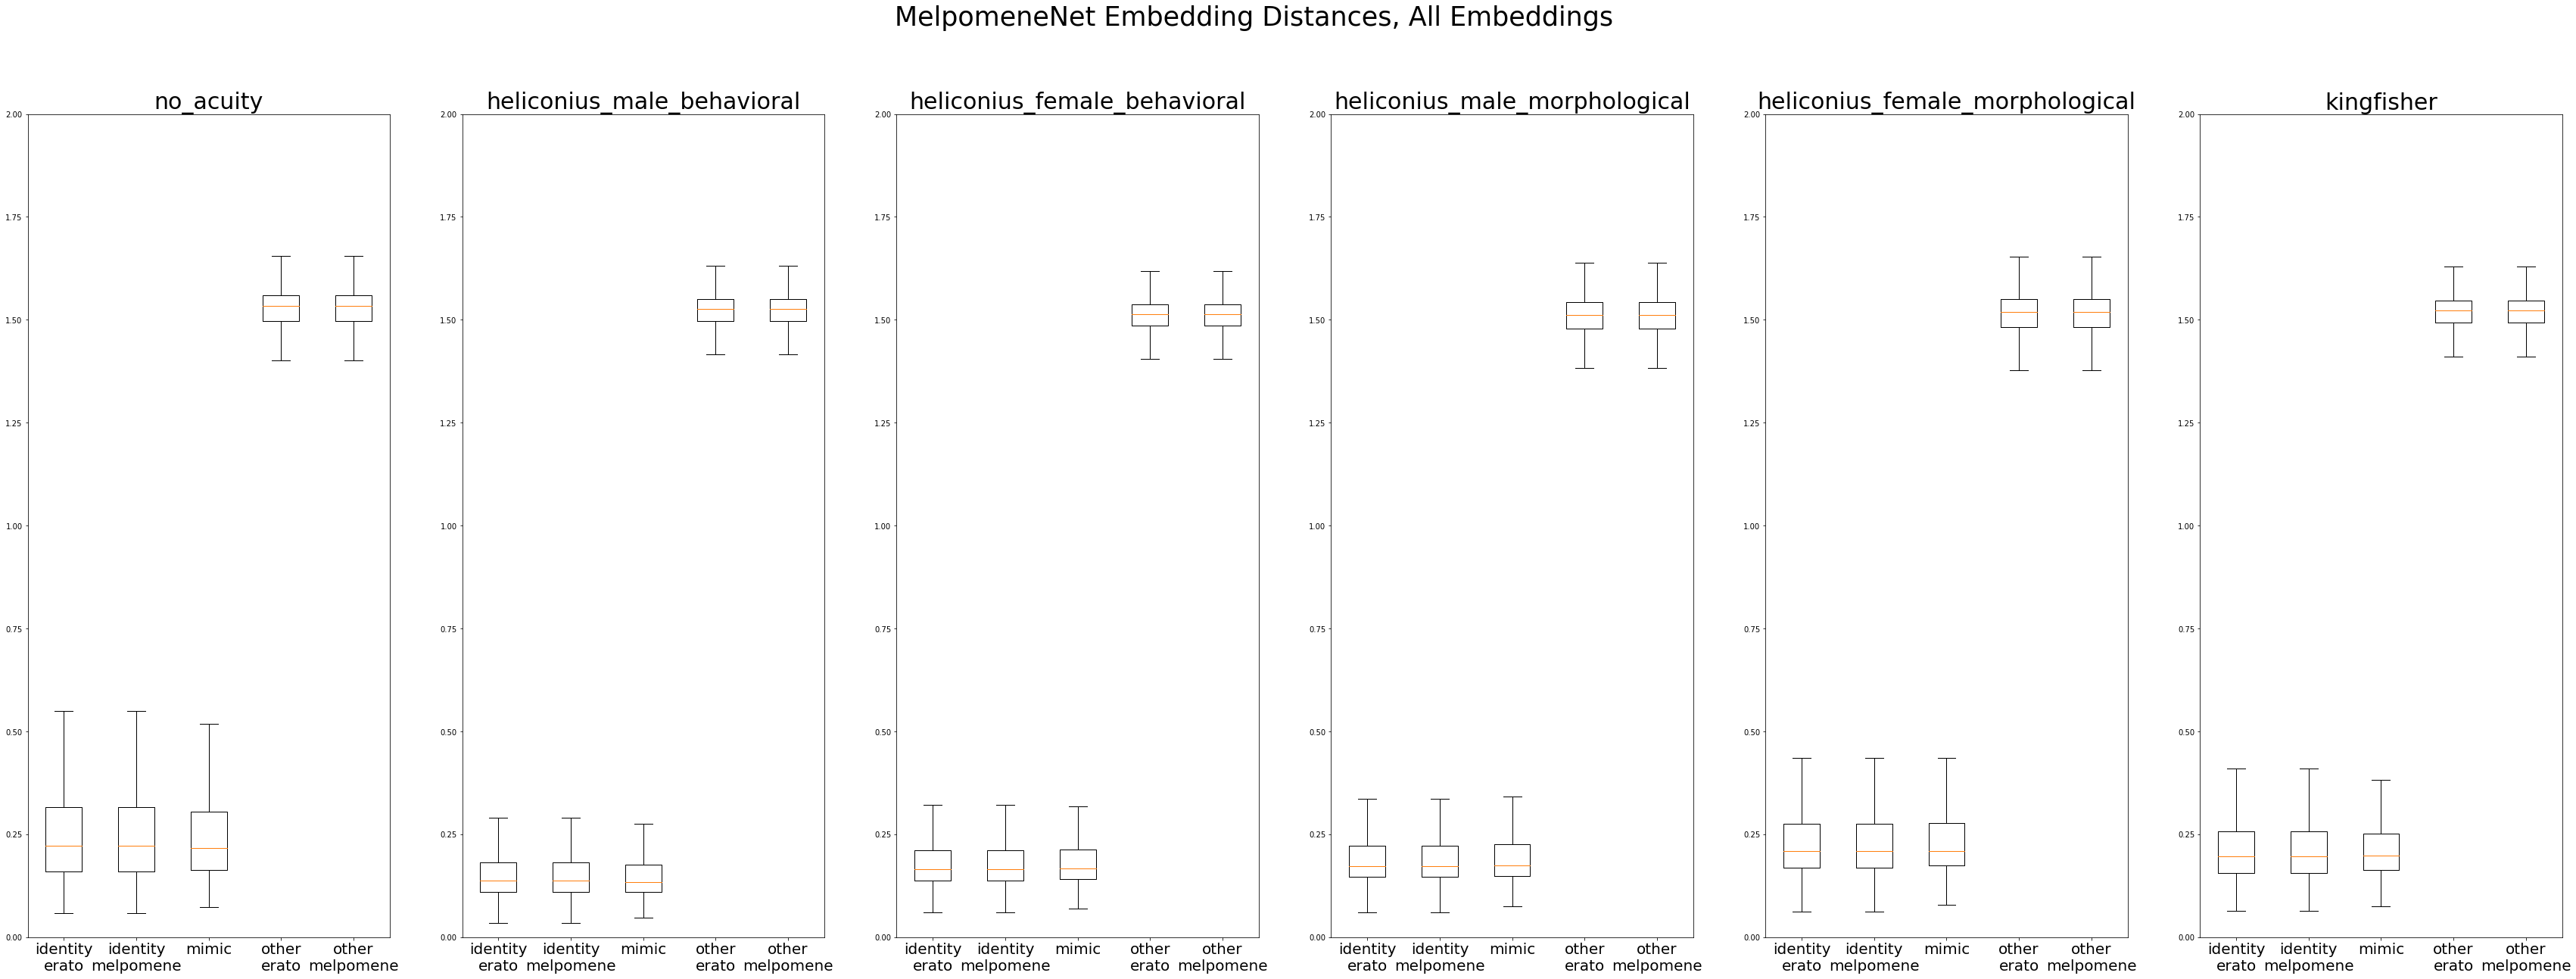

In [80]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(60, 20))
fig.suptitle(f"{model_name} Embedding Distances, All Embeddings", fontsize=35)

dfs = []
col = 0
for n, (test_embeddings, test_labels) in zip(names, zip(all_embeddings.values(), all_labels.values())):
# for n, (test_embeddings, test_labels) in zip([names[-1]], zip(all_embeddings.values(), all_labels.values())): #sanity check for kingfisher
    # Create species_embeddings dictionary where are embeddings belonging to 
    # one subspecies are appended together in a list as the values.
    # Ex: species_embeddings = {ss: [[embedding1], [embedding2], etc.]}
    print(n)
    species_embeddings = dict()
    for ss in np.unique(test_labels):
        species_embeddings[ss] = []

    for embedding, label in zip(test_embeddings, test_labels):
        species_embeddings[label].append(embedding)

    # calculate the pairwise euclidean distances for each acuity and create boxplot
    df = get_boxplot_separate(species_embeddings, erato_list, melpomene_list, acuity=n, ax=axs[col])
    dfs.append(df)
    axs[col].set_title(f'{n}', fontsize=30)
    col += 1

boxplot_df = pd.concat(dfs, ignore_index=True)

In [81]:
boxplot_df

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker,acuity
0,identity erato,0.058335,0.159964,0.221770,0.315713,0.549336,no_acuity
1,identity melpomene,0.058335,0.159964,0.221770,0.315713,0.549336,no_acuity
2,mimic,0.074007,0.162489,0.216954,0.305042,0.518869,no_acuity
3,other erato,1.401236,1.496304,1.532930,1.559682,1.654749,no_acuity
4,other melpomene,1.401236,1.496304,1.532930,1.559682,1.654749,no_acuity
5,identity erato,0.034845,0.110745,0.137936,0.182467,0.290050,heliconius_male_behavioral
6,identity melpomene,0.034845,0.110745,0.137936,0.182467,0.290050,heliconius_male_behavioral
7,mimic,0.048258,0.110546,0.134477,0.176905,0.276444,heliconius_male_behavioral
8,other erato,1.416169,1.496803,1.527394,1.550559,1.631191,heliconius_male_behavioral
9,other melpomene,1.416169,1.496803,1.527394,1.550559,1.631191,heliconius_male_behavioral


In [85]:
model_name

'MelpomeneNet'

`MelpomeneNet Kingfisher Embeddings`: seeing a smaller variance and smaller mean embedding distance b/w comimics for kingfisher acuity is indicative of confusion of comimics by a bird predator

`Other notes`:
- The goal of the 'other' category being seperated by erato and melpomene is to showcase that mimics (erato-melpomene) are closer in the embedding space to each other than to members of its own species (ex. erato). 

In [83]:
from src.dir_paths.figures_paths import get_figures_path
plot_path = get_figures_path(acuity, model_name)
plot_path = plot_path.replace(plot_path.split('/')[-1], "") #save to general folder since it uses all acuities
print(plot_path)
# # fig.savefig(plot_path+"embedding_distances_boxplot_eratonet_kingfisher.png", bbox_inches="tight") 
# fig.savefig(plot_path+"embedding_distances_boxplot.png", bbox_inches="tight") 

/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/MelpomeneNet/


In [84]:
# get_boxplot_separate(original, data, labels, subspecies, ax=axs[0,0])
# get_boxplot_separate(same, data, labels, subspecies, ax=axs[0,1])
# get_boxplot_separate(nonmimic, data, labels, subspecies, ax=axs[0,2])
# get_boxplot_separate(comimic, data, labels, subspecies, ax=axs[0,3])
# get_boxplot_separate(negative, test_loader, labels, subspecies, ax=axs[1,0], negative=True)
# get_boxplot_separate(mimetic, data_s, labels_s, subspecies_s, ax=axs[1,1])
# get_boxplot_separate(erato, data, labels, subspecies, ax=axs[1,2])
# get_boxplot_separate(melpomene, data, labels, subspecies, ax=axs[1,3])

# axs[0,0].set_title('ButterflyNet', fontsize=30)
# axs[0,1].set_title('SpeciesNet', fontsize=30)
# axs[0,2].set_title('NonmimicNet', fontsize=30)
# axs[0,3].set_title('ComimicNet', fontsize=30)
# axs[1,0].set_title('NegativeNet', fontsize=30)
# axs[1,1].set_title('MimicryLabelsNet', fontsize=30)
# axs[1,2].set_title('EratoNet', fontsize=30)
# axs[1,3].set_title('MelpomeneNet', fontsize=30)